<a href="https://colab.research.google.com/github/CasadoPedro/TP2_AA2_P2/blob/main/AA2_TP2_P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Trabajo Práctico N° 2 Aprendizaje Automático II 2025**

### **Redes Recurrentes y Reinforcement Learning**

---
**Alumnos:**


*   **Casado Pedro**

*   **Leguiza Claudia E.**

---



### **PROBLEMA 1**

## Librerias

In [211]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from sklearn.metrics import confusion_matrix


# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

Establecer GPU por defecto en caso de estar disponible.

In [212]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Descargar Dataset

In [213]:
(ds_train, ds_val), info = tfds.load('spoken_digit', split=['train[:80%]', 'train[80%:]'], as_supervised=True, with_info=True)

In [214]:
print(info.splits)

{'train': <SplitInfo num_examples=2500, num_shards=1>}


In [167]:
print(info.features)

FeaturesDict({
    'audio': Audio(shape=(None,), dtype=int64),
    'audio/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})


In [168]:
print(info.features["label"].names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [169]:
print(info.description)

A free audio dataset of spoken digits. Think MNIST for audio.

A simple audio/speech dataset consisting of recordings of spoken digits in wav
files at 8kHz.
The recordings are trimmed so that they have near minimal silence at the
beginnings and ends.

5 speakers\
2,500 recordings (50 of each digit per speaker)\
English pronunciations

Files are named in the following format: {digitLabel}_{speakerName}_{index}.wav


## Preprocesamiento de los datos

In [170]:
len(ds_train), len(ds_val)

(2000, 500)

Dividimos el dataset en train(80%) y validacion(20%), quedando 2000 muestras para train y 500 para validacion.

Verificamos los datos de train

In [171]:
ds_train.element_spec

(TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

La especificación de los tensores describe la forma y el tipo de datos del conjunto de datos.

- TensorSpec(shape=(None,), dtype=tf.int64): representa el input, que sería una secuencia de enteros( representación codificada del audio).

- TensorSpec(shape=(), dtype=tf.int64): representa la etiqueta (label), que es un solo entero correspondiente al dígito hablado en el audio (0 al 9).




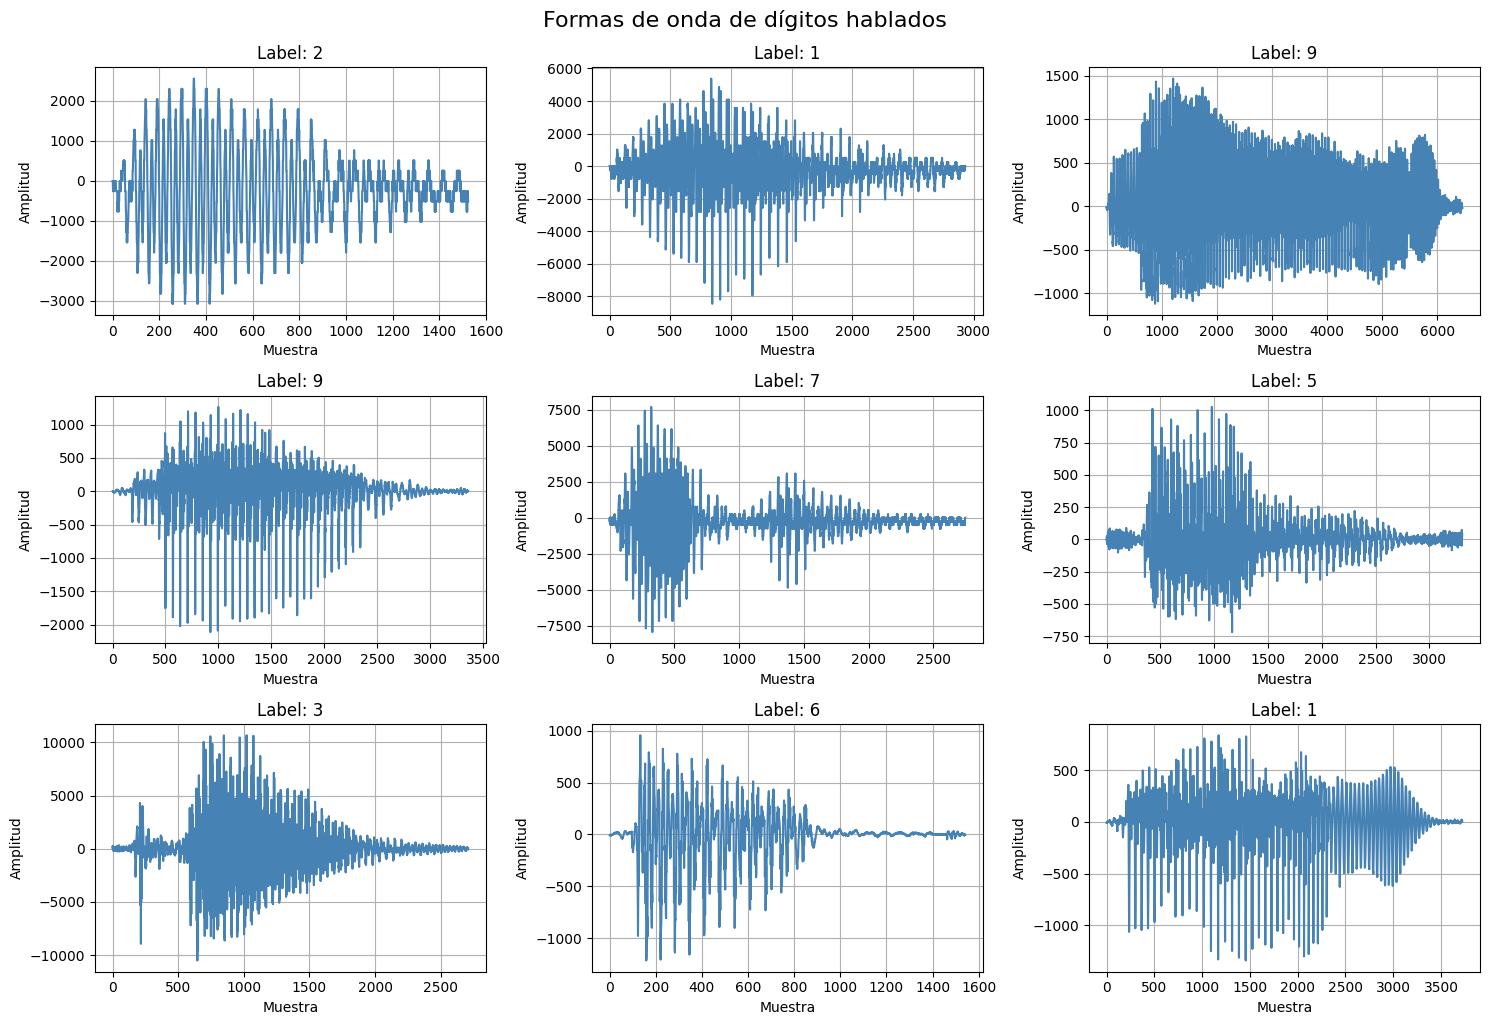

In [172]:
# Visualizamos algunos ejemplos de audios
plt.figure(figsize=(15, 10))

# Tomamos los primeros 9 ejemplos
for i, (audio, label) in enumerate(ds_train.take(9)):
    audio = tf.reshape(audio, [-1])
    audio_np = audio.numpy()

    plt.subplot(3, 3, i + 1)
    plt.plot(audio_np, color='steelblue')
    plt.title(f"Label: {label.numpy()}")
    plt.xlabel("Muestra")
    plt.ylabel("Amplitud")
    plt.grid(True)

plt.tight_layout()
plt.suptitle("Formas de onda de dígitos hablados", fontsize=16, y=1.02)
plt.show()

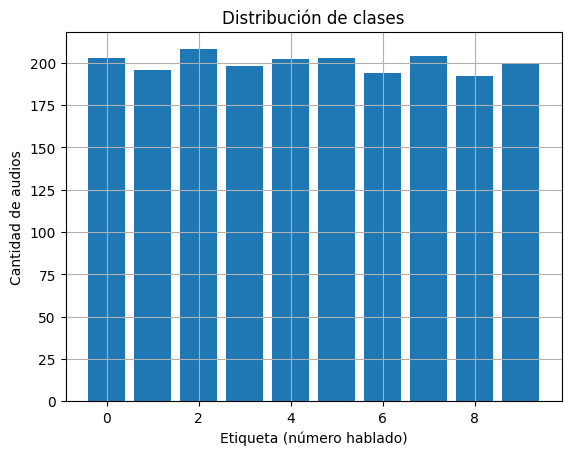

In [173]:
import collections

labels = [label for _, label in tfds.as_numpy(ds_train)]
counter = collections.Counter(labels)
plt.bar(counter.keys(),counter.values())
plt.xlabel("Etiqueta (número hablado)")
plt.ylabel("Cantidad de audios")
plt.title("Distribución de clases")
plt.grid(True)
plt.show()

El grafica de barras nos permite ver que el conjunto de datos de train esta balanceado.

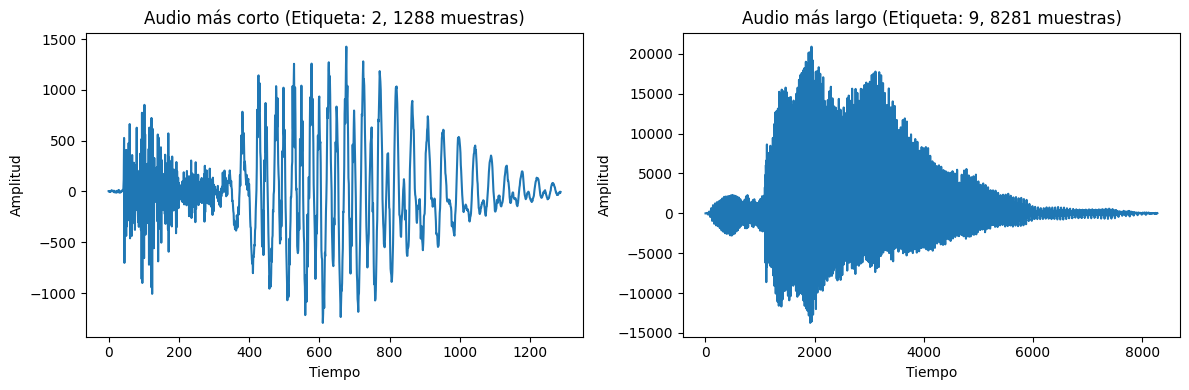

In [174]:
# Convertir a lista de NumPy para inspeccionar
audios_numpy = list(tfds.as_numpy(ds_train))

longitudes = [len(audio) for audio, _ in audios_numpy]
idx_min = np.argmin(longitudes)
idx_max = np.argmax(longitudes)

audio_corto, label_corto = audios_numpy[idx_min]
audio_largo, label_largo = audios_numpy[idx_max]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(audio_corto)
plt.title(f"Audio más corto (Etiqueta: {label_corto}, {len(audio_corto)} muestras)")
plt.xlabel("Tiempo")
plt.ylabel("Amplitud")

plt.subplot(1, 2, 2)
plt.plot(audio_largo)
plt.title(f"Audio más largo (Etiqueta: {label_largo}, {len(audio_largo)} muestras)")
plt.xlabel("Tiempo")
plt.ylabel("Amplitud")

plt.tight_layout()
plt.show()

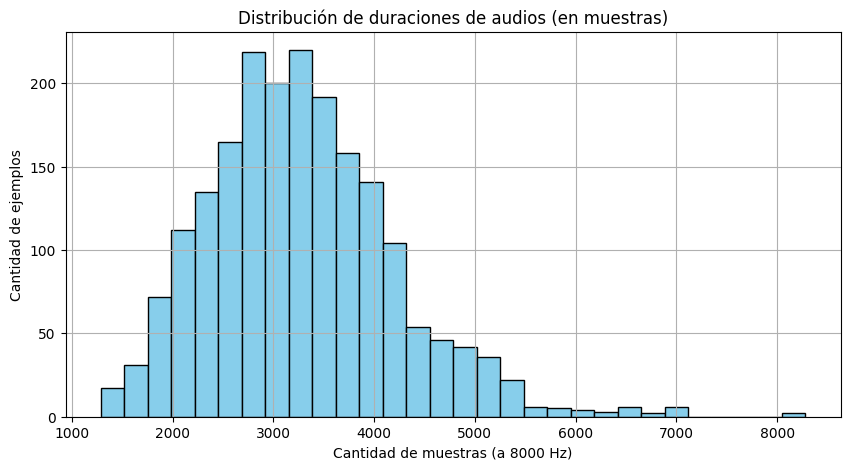

In [175]:
plt.figure(figsize=(10, 5))
plt.hist(longitudes, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribución de duraciones de audios (en muestras)")
plt.xlabel("Cantidad de muestras (a 8000 Hz)")
plt.ylabel("Cantidad de ejemplos")
plt.grid(True)
plt.show()

In [176]:
print("Cantidad total de ejemplos:", len(longitudes))
print("Duración mínima:", np.min(longitudes))
print("Duración máxima:", np.max(longitudes))
print("Media:", np.mean(longitudes))
print("Mediana:", np.median(longitudes))
print("Percentil 99:", np.percentile(longitudes, 99))


Cantidad total de ejemplos: 2000
Duración mínima: 1288
Duración máxima: 8281
Media: 3281.6235
Mediana: 3200.0
Percentil 99: 6112.1


Vamos a normalizar la duracion de los audios a 6113 muestras ya que 99% de los audios tiene una duracion menor a este valor. Tomamos esta decision para asegurarnos que la parte hablada del audio fuera correctamente evaluada(observar grafico de audio mas largo).

In [177]:
FIXED_LENGTH = 6113

# Funcion para rellenar los audios y normalizar la salida
def process_audio(audio, label):
    audio = tf.reshape(audio, [-1])  # Asegura que sea vector 1D
    audio_len = tf.shape(audio)[0]

    audio = tf.cond(audio_len > FIXED_LENGTH,
                    lambda: audio[:FIXED_LENGTH],
                    lambda: tf.pad(audio, [[0, FIXED_LENGTH - audio_len]]))
    #Normalizamos el audio de -1 a 1
    audio = tf.cast(audio, tf.float32)
    max_val = tf.reduce_max(tf.abs(audio))
    audio = audio / max_val
    return audio, label

In [178]:
# Aplicar procesamiento
data_train = ds_train.map(process_audio)
data_val = ds_val.map(process_audio)

In [179]:
BATCH_SIZE = 32

data_train = data_train.shuffle(256).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
data_val = data_val.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Organizamos los conjuntos data_train y data_val en batches de tamaño 32. Los datos se mezclan aleatoriamente con un búfer de 256 ejemplos


Corroboramos que la estructura sea la correcta:  32 audios por batch, cada uno de longitud 6113, y sus respectivas 32 etiquetas.

In [180]:
for batch in data_train.take(1):
    x, y = batch
    print("Shape del batch de entrada:", x.shape)
    print("Shape del batch de etiquetas:", y.shape)

Shape del batch de entrada: (32, 6113)
Shape del batch de etiquetas: (32,)


##Crear Espectogramas

In [181]:
def get_spectrogram(waveform):
  # Convierte la forma de onda en un espectograma via a STFT(Transformada de Fourier de corta duración)
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Divide el audio en pequeños fragmentos solapados y calcula su contenido en frecuencias.
  # Esto convierte la señal 1D en una representación 2D: tiempo × frecuencia.

  # Descarta la fase y queda solo con la intensidad de las frecuencias.
  spectrogram = tf.abs(spectrogram)

  # Esto lo deja listo para redes convolucionales tipo CNN, que esperan una imagen
  # en escala de grises: alto × ancho × canales.
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [182]:
def plot_spectrogram(spectrogram, ax):
    # Asegura que tenga forma [frecuencia, tiempo] o [frecuencia, tiempo, 1]
    if spectrogram.ndim == 3 and spectrogram.shape[-1] == 1:
        spectrogram = np.squeeze(spectrogram, axis=-1)
    elif spectrogram.ndim != 2:
        raise ValueError("El espectrograma debe tener 2 o 3 dimensiones")

    # Transforma la escala lineal de magnitudes a logarítmica.
    # Esto resalta mejor los detalles en frecuencias bajas (muy útil en audio).
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height, width = log_spec.shape
    X = np.linspace(0, spectrogram.shape[0], num=width)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

Tomamos tres ejemplos y graficamos la forma de onda con su respectivo espectograma y el audio correspondiente.

In [183]:
for i, (audio, label) in enumerate(ds_train.take(6)):
    waveform = tf.cast(audio, tf.float32)  # Aquí realizamos la conversión

    print('Label:', label.numpy())  # Convertir a numpy para evitar problemas con los tensores
    print('Waveform shape:', waveform.shape)
    print('Audio playback')
    display.display(display.Audio(waveform.numpy(), rate=6113))  # Convertir a numpy para compatibilidad con display

Label: 2
Waveform shape: (1525,)
Audio playback


Label: 1
Waveform shape: (2929,)
Audio playback


Label: 9
Waveform shape: (6457,)
Audio playback


Label: 9
Waveform shape: (3360,)
Audio playback


Label: 7
Waveform shape: (2746,)
Audio playback


Label: 5
Waveform shape: (3306,)
Audio playback


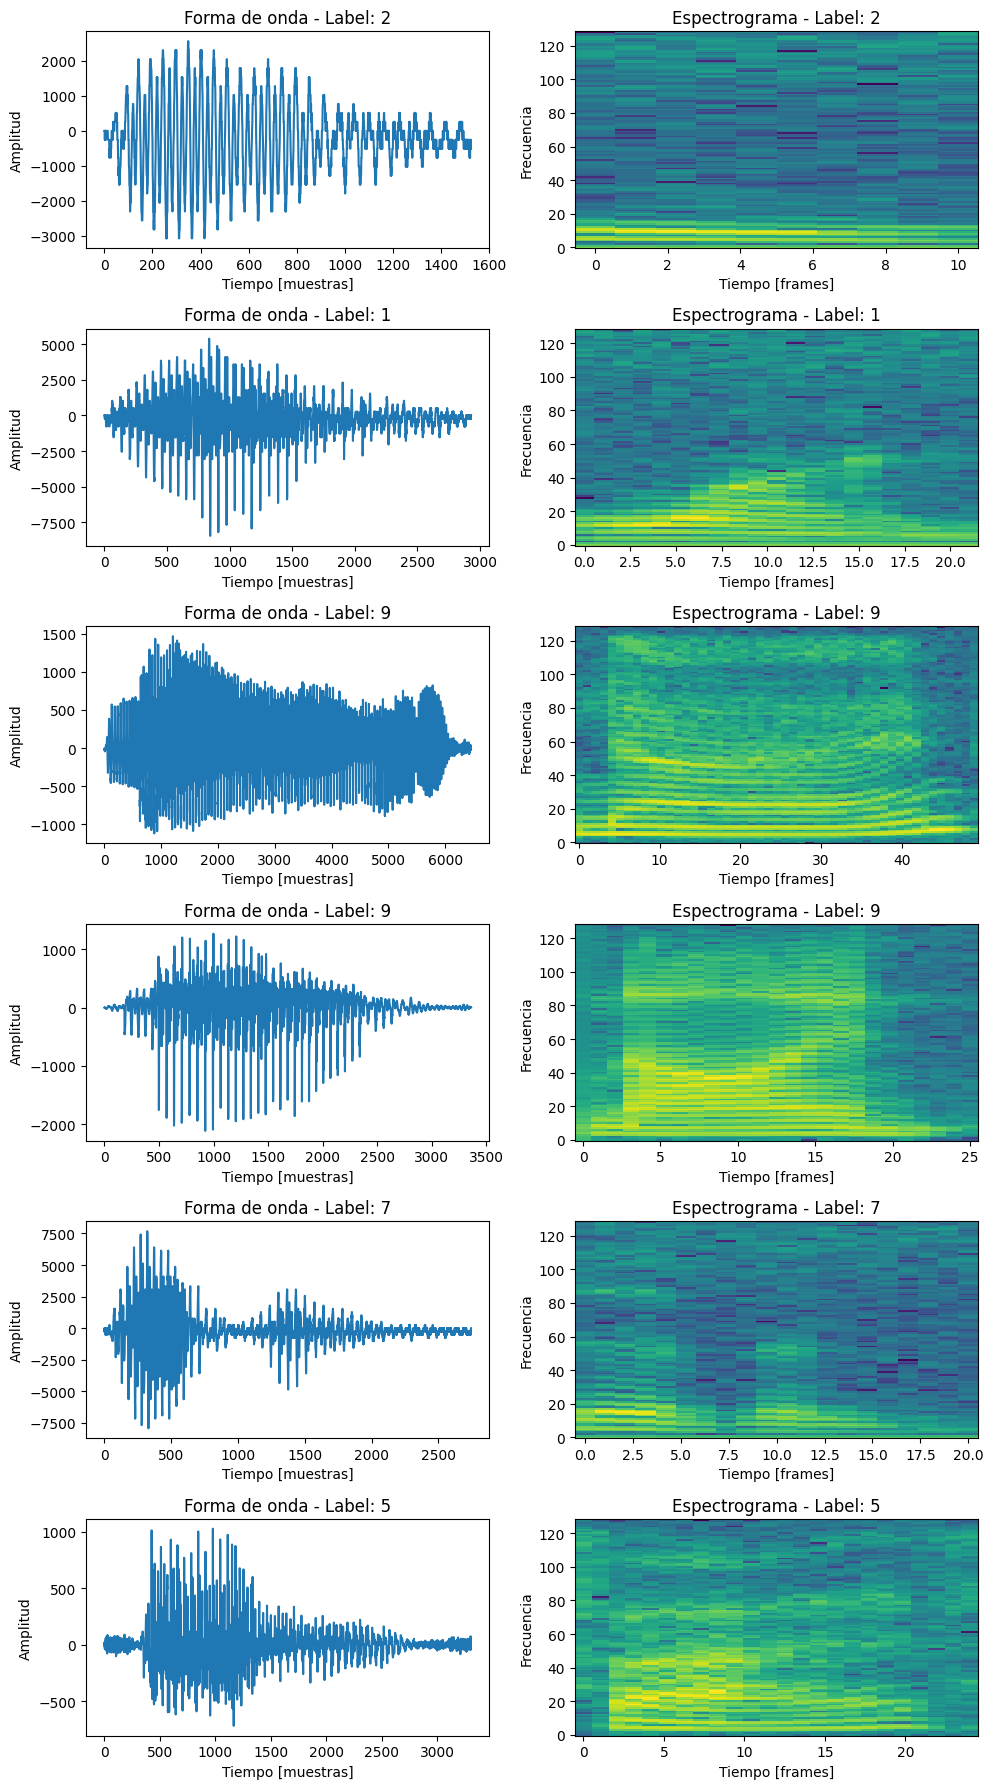

In [184]:
num_examples = 6
fig, axes = plt.subplots(num_examples, 2, figsize=(10, num_examples * 3))

for i, (audio, label) in enumerate(ds_train.take(num_examples)):
    waveform = tf.cast(audio, tf.float32)
    spectrogram = get_spectrogram(waveform)

    # Plot waveform
    axes[i, 0].plot(np.arange(waveform.shape[0]), waveform.numpy())
    axes[i, 0].set_title(f'Forma de onda - Label: {label.numpy()}')
    axes[i, 0].set_xlabel('Tiempo [muestras]')
    axes[i, 0].set_ylabel('Amplitud')

    # Plot spectrogram
    plot_spectrogram(spectrogram.numpy(), axes[i, 1])
    axes[i, 1].set_title(f'Espectrograma - Label: {label.numpy()}')
    axes[i, 1].set_xlabel('Tiempo [frames]')
    axes[i, 1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Los audios mas cortos son menos audibles.

La duracion de la onda en el tiempo nos indica que algunos numeros se pronuncian mas rapido.Dentro de la misma clase la grafica varia pues depende del timbre de voz y acento de quien habla.

En el espectograma, la intensidad del color representa cuánta energía hay en cada frecuencia a lo largo del tiempo.El patron es diferente para cada clase pero se asemeja dentro  de la misma clase.

Utilizamos la siguiente funcion para transformar el conjunto de datos de audio en un conjunto de espectrogramas.

In [185]:
def make_spec_ds(ds):
  return ds.map( lambda audio, label: (get_spectrogram(tf.cast(audio, tf.float32)),\
                                       label), num_parallel_calls=tf.data.AUTOTUNE )

# tf.cast(audio, tf.float32): Asegura que el audio esté en el formato de punto flotante que espera la red neuronal.
# get_spectrogram(...): Convierte la forma de onda en un espectrograma 2D, una especie de imagen del sonido.
# ds.map(...): Aplica esta transformación a cada par (audio, label) del dataset.
# num_parallel_calls=tf.data.AUTOTUNE: Optimiza la carga y el procesamiento usando múltiples hilos en paralelo.


In [186]:
train_spectrogram_ds = make_spec_ds(data_train)
val_spectrogram_ds = make_spec_ds(data_val)

##Modelo CNN


In [187]:
for spec, label in train_spectrogram_ds.take(1):
    print(spec.shape)

(32, 46, 129, 1)


In [188]:
label_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [189]:
input_shape = spec.shape[1:]
num_labels = len(label_names)

# Capa de normalización adaptada al dataset
norm_layer = layers.Normalization()
norm_layer.adapt(train_spectrogram_ds.map(lambda spec, label: spec))

In [190]:
model = models.Sequential([
    layers.Input(shape=input_shape),

    # Redimensionamiento uniforme
    layers.Resizing(64, 64),

    # Normalización (Z-score)
    norm_layer,

    layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.25),

    layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.30),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(num_labels, activation='softmax'),
])

In [191]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_8 (Resizing)           │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_10                │ (None, 64, 64, 1)      │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,477 (431.55 KB)

 Trainable params: 110,474 (431.54 KB)

 Non-trainable params: 3 (16.00 B)

In [192]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [193]:
EPOCHS = 100
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=10),
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.0949 - loss: 2.3025 - val_accuracy: 0.0940 - val_loss: 2.2885
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1226 - loss: 2.2772 - val_accuracy: 0.2340 - val_loss: 2.1587
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2358 - loss: 2.0530 - val_accuracy: 0.3760 - val_loss: 1.6545
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3393 - loss: 1.7414 - val_accuracy: 0.4760 - val_loss: 1.4645
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4022 - loss: 1.5706 - val_accuracy: 0.5180 - val_loss: 1.3276
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4627 - loss: 1.3977 - val_accuracy: 0.5680 - val_loss: 1.2263
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4772 - loss: 1.3622 - val_accuracy: 0.5780 - val_loss: 1.1653
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5122 - loss: 1.2529 - val_accuracy: 0.5880 - val_l

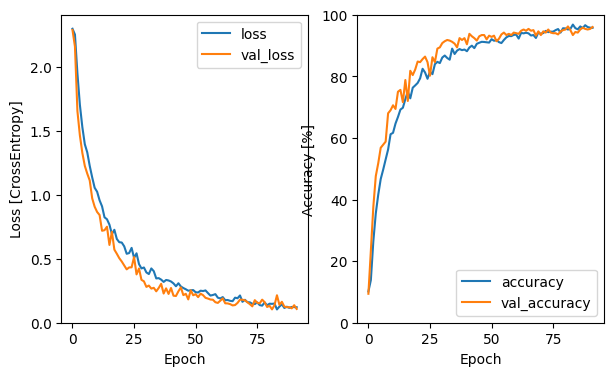

In [194]:
metrics = history.history
plt.figure(figsize=(7, 4))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.show()


  **Curva de pérdida (loss)**
- Ambas curvas bajan consistentemente, tanto en entrenamiento como en validación.

**Curva de precisión (accuracy)**
- Ambas aumentan de forma estable, lo que indica que el modelo sigue aprendiendo sin saturarse.

**Conclusión:** el modelo es preciso y generaliza bien. No hay signos de sobreajuste ni subentrenamiento







## Matriz de confusion

In [195]:
y_true = []
y_pred = []

for spectrograms, labels in val_spectrogram_ds:
    predictions = model.predict(spectrograms)
    predicted_labels = tf.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


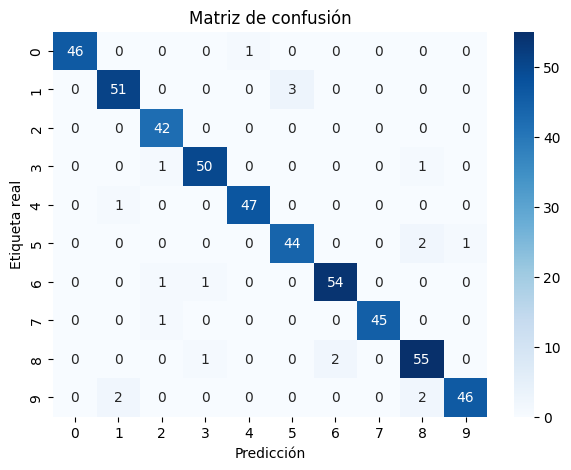

In [196]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de confusión")
plt.show()

- El modelo distingue correctamente entre la mayoría de las clases.

Se observa que:
-  el "3" fue etiquetado como "2" en 1 oportunidad y una vez con "8',
- el "4" una vez con el "1"
-  el "8" se etiqueto como "3" , una vez, como "6", dos veces
- el "1", tres veces como "5"
- el "5" se etiqueto erroneamente dos veces como "8" y una vez como "9"
- el "6" una vez como "2" y una como "3"
- el "7" una vez como "2"
- el "9" dos veces como "1" y dos veces como "8"



Visualizamos algunos espectogramas incorrectos

In [197]:
incorrect_specs = []
incorrect_preds = []
incorrect_labels = []

for spectrograms, labels in val_spectrogram_ds:
    preds = model.predict(spectrograms)
    pred_labels = tf.argmax(preds, axis=1)

    for spec, pred, true in zip(spectrograms, pred_labels, labels):
        if pred != true:
            incorrect_specs.append(spec)
            incorrect_preds.append(pred.numpy())
            incorrect_labels.append(true.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


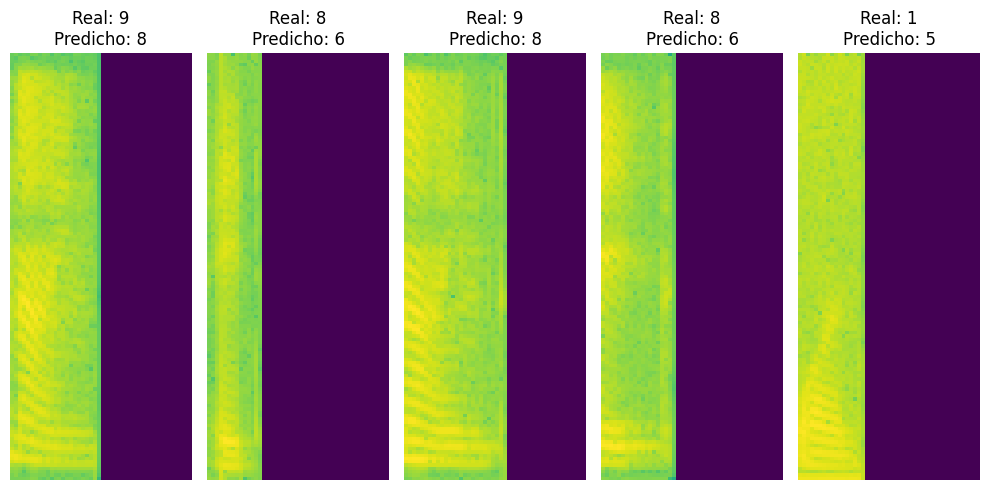

In [198]:
plt.figure(figsize=(10, 5))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plot_spectrogram(incorrect_specs[i], ax)
    ax.set_title(f"Real: {incorrect_labels[i]}\nPredicho: {incorrect_preds[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()



Los errores pueden deberse a la calidad del audio o la pronunciacion del hablante

##Modelo RNN

In [199]:
for x_train, _ in train_spectrogram_ds.take(1):
    print("Antes del squeeze:", x.shape)

Antes del squeeze: (32, 6113)


In [200]:
#Eliminamos el último canal para poder procesarlo como RNN
train_spectrogram_rnn = train_spectrogram_ds.map(lambda x, y: (tf.squeeze(x, axis=-1), y))
val_spectrogram_rnn = val_spectrogram_ds.map(lambda x, y: (tf.squeeze(x, axis=-1), y))

In [201]:
for x_train, _ in train_spectrogram_rnn.take(1):
    print("Después del squeeze:", x.shape)

Después del squeeze: (32, 6113)


In [202]:
for x, _ in val_spectrogram_rnn.take(1):
    print("Después del squeeze:", x.shape)

Después del squeeze: (32, 46, 129)


**Las capas LSTM (Long Short-Term Memory):**

 son un tipo especial de red neuronal recurrente (RNN) diseñadas para aprender dependencias temporales en secuencias, es decir,
sirven para reconocer patrones que dependen del orden y del contexto en el tiempo.

Como estamos trabajando con espectrogramas de audio (que son secuencias temporales de características acústicas), la LSTM:
- Aprende mejor cómo ciertos sonidos evolucionan a lo largo del tiempo
- Captura la dinámica de pronunciar un número (por ejemplo, cómo cambia la frecuencia entre el comienzo de un “nueve” vs un “cinco”)
- No solo mira un instante aislado del audio, sino que “recuerda” lo que ocurrió antes.







In [203]:
input_shape = x_train.shape[1:]
num_labels = len(label_names)

# Capa de normalización adaptada al dataset
norm_layer = layers.Normalization()
norm_layer.adapt(train_spectrogram_rnn.map(lambda spec, label: spec))

In [204]:
model_rnn = models.Sequential([
    layers.Input(shape=(None, 129)),  # 129 bins si fft_length=256

    layers.LSTM(128, return_sequences=True),

    layers.LSTM(64, return_sequences=False),


    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),


    layers.Dense(num_labels, activation='softmax')
])


In [205]:
model_rnn.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, None, 128)      │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,730 (776.29 KB)

 Trainable params: 198,730 (776.29 KB)

 Non-trainable params: 0 (0.00 B)

In [206]:
model_rnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [207]:
EPOCHS = 50

history = model_rnn.fit(
    train_spectrogram_rnn,
    validation_data=val_spectrogram_rnn,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=10),
    epochs=EPOCHS
)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.2215 - loss: 2.0839 - val_accuracy: 0.4400 - val_loss: 1.2455
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5386 - loss: 1.1108 - val_accuracy: 0.5040 - val_loss: 1.1295
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6468 - loss: 0.8258 - val_accuracy: 0.7140 - val_loss: 0.7312
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7772 - loss: 0.5571 - val_accuracy: 0.8020 - val_loss: 0.5085
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8437 - loss: 0.4473 - val_accuracy: 0.8280 - val_loss: 0.4547
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8939 - loss: 0.3006 - val_accuracy: 0.9160 - val_loss: 0.3069
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9385 - loss: 0.2152 - val_accuracy: 0.9180 - val_loss: 0.2778
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9164 - loss: 0.2928 - val_accuracy: 0.8400 - v

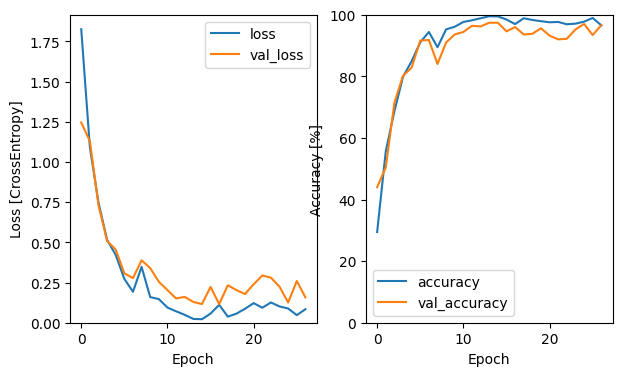

In [208]:
metrics = history.history
plt.figure(figsize=(7, 4))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.show()

- La precisión sube consistentemente tanto en entrenamiento como en validación.

- La validación va muy cerca del entrenamiento, lo que es señal de buena generalización.



## Matriz de confusion

In [209]:
y_true = []
y_pred = []

for spectrograms, labels in val_spectrogram_rnn:
    predictions = model_rnn.predict(spectrograms)
    predicted_labels = tf.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


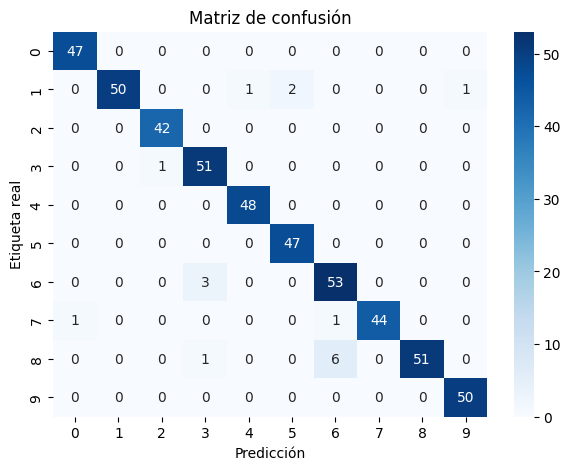

In [210]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de confusión")
plt.show()

- Casi todos los valores están concentrados sobre la diagonal principal, lo que indica predicciones correctas para la mayoría de los dígitos.

 Errores más frecuentes:

- El dígito "8" fue confundido seis veces con el "6".
- El "1" se predijo como 5 , dos veces , una vez como "4" y una vez como "9".
- El "6" tres veces como "3"
- El "7" se etiqueto una vez como "0" y una vez como "6"


## **Conclusiones finales**

Ambos modelos anduvieron muy bien en la prediccion de numeros.Los errores son mayormente entre numeros foneticamente parecidos, algo esperable en reconocimiento de voz.
 El modelo convolucional tiene menor cantidad de parametros y las curvas de loss y accuracy mas cercanas entre entrenamiento y validacion generalizando levemente mejor.